In [5]:
!unzip /content/archive2.zip

Archive:  /content/archive2.zip
replace README_rpc-cv-images.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Found 2188 files belonging to 3 classes.
Using 1751 files for training.
Found 2188 files belonging to 3 classes.
Using 437 files for validation.
Classes: ['paper', 'rock', 'scissors']


/tmp/ipython-input-3184491030.py:53: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 50s 374ms/step - accuracy: 0.6218 - loss: 0.8358 - val_accuracy: 0.9611 - val_loss: 0.1562
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9658 - loss: 0.1220 - val_accuracy: 0.9817 - val_loss: 0.0577
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9830 - loss: 0.0617 - val_accuracy: 0.9840 - val_loss: 0.0673
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9780 - loss: 0.0648 - val_accuracy: 0.9931 - val_loss: 0.0202
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9933 - loss: 0.0238 - val_accuracy: 0.9908 - val_loss: 0.0384
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9925 - loss: 0.0235 - val_accuracy: 0.9931 - val_loss: 0.0341
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9963 - loss: 0.0153 - val_accuracy: 0.9931 - val_loss: 0.0325
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9984 - loss: 0.0095 - val_accuracy: 0

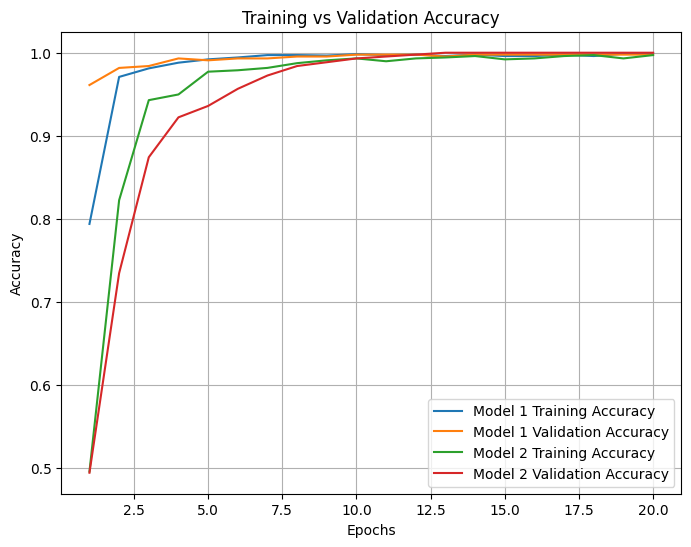

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

DATASET_DIR = "/content/rps-cv-images"
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
SEED = 123

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_ds.class_names
print("Classes:", class_names)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

normalization = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization(x), y))
val_ds = val_ds.map(lambda x, y: (normalization(x), y))

train_ds = train_ds.shuffle(1000)
val_ds = val_ds.shuffle(1000)

def create_model(dropout_rate=0.4, dense_units=128, learning_rate=1e-4, fine_tune_layers=50):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(150,150,3),
        include_top=False,
        weights="imagenet"
    )

    base_model.trainable = True
    for layer in base_model.layers[:-fine_tune_layers]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(dense_units, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(dense_units//2, activation="relu"),
        layers.Dropout(dropout_rate/2),
        layers.Dense(3, activation="softmax")
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

model_1 = create_model(dropout_rate=0.4, dense_units=128, learning_rate=1e-4, fine_tune_layers=50)
history_1 = model_1.fit(train_ds, validation_data=val_ds, epochs=20)

model_2 = create_model(dropout_rate=0.5, dense_units=256, learning_rate=3e-5, fine_tune_layers=100)
history_2 = model_2.fit(train_ds, validation_data=val_ds, epochs=20)

def predict_and_show(model, img_path):
    img = image.load_img(img_path, target_size=(150,150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    label = class_names[np.argmax(preds)]
    confidence = np.max(preds) * 100

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {label} ({confidence:.2f}%)",
              fontsize=12, color="green")
    plt.show()



acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']

acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']

epochs = range(1, len(acc_1) + 1)

plt.figure(figsize=(8, 6))

plt.plot(epochs, acc_1, label='Model 1 Training Accuracy')
plt.plot(epochs, val_acc_1, label='Model 1 Validation Accuracy')

plt.plot(epochs, acc_2, label='Model 2 Training Accuracy')
plt.plot(epochs, val_acc_2, label='Model 2 Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


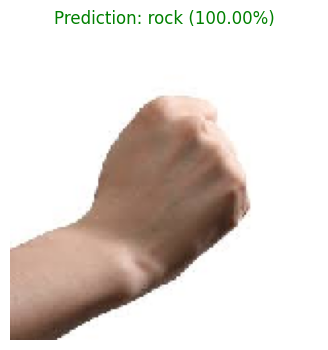

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


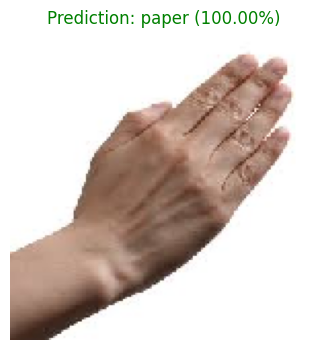

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


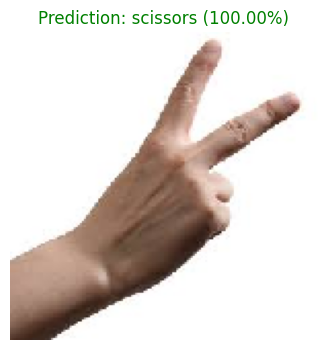

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


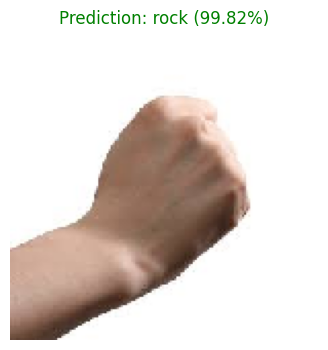

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


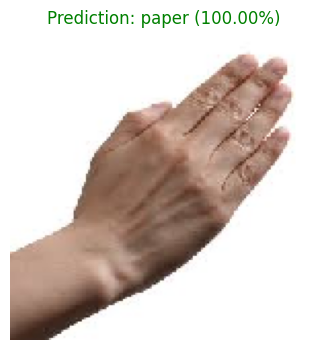

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


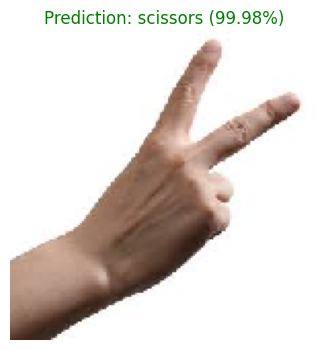

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


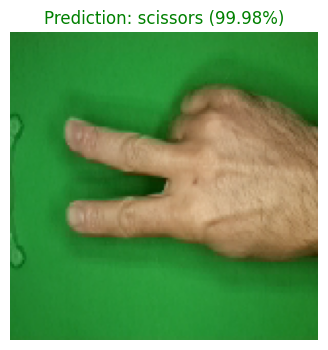

In [10]:
predict_and_show(model_1, "/content/fed.png")
predict_and_show(model_1, "/content/fed1.png")
predict_and_show(model_1, "/content/fed2.png")

predict_and_show(model_2, "/content/fed.png")
predict_and_show(model_2, "/content/fed1.png")
predict_and_show(model_2, "/content/fed2.png")
predict_and_show(model_2, "/content/scissors/2M8LvUBGMOH1bsaz.png")
